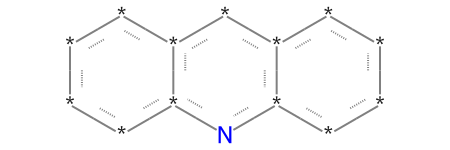

In [11]:
smarts = '[N;D2]1*2*(**3*1****3)****2'
query = Chem.MolFromSmarts(smarts)
query

In [12]:
mols_file = 'mcule_bb_mols.pkl'
names_file = 'mcule_bb_names.pkl'

import pickle
with open(mols_file, "rb") as f:
    mols = pickle.load(f)

with open(names_file, "rb") as f:
    names = pickle.load(f)

print(len(mols), len(names))

3643758 3643758


In [14]:
from rdkit import Chem
from rdkit.Chem import Draw
from joblib import Parallel, delayed
from multiprocessing import cpu_count
from rdkit.Chem import MolToInchiKey

# CPU 갯수 구하기
num_cpus = 8 # cpu_count() // 4

# mols 리스트를 CPU 갯수만큼 나누기
mols_per_cpu = len(mols) // 80 # (num_cpus*10)
mols_list = [mols[i:i+mols_per_cpu] for i in range(0, len(mols), mols_per_cpu)]

# 병렬 처리
results = Parallel(n_jobs=num_cpus, verbose=10)(delayed(lambda mols_chunk: [mol.HasSubstructMatch(query) for mol in mols_chunk])(mols_chunk) for mols_chunk in mols_list)

# 결과 순서대로 정렬
matched_indices = []
for i in range(0, len(mols), mols_per_cpu):
    matched_indices += results[i//mols_per_cpu]
matched_mols = [mols[i] for i in range(len(mols)) if matched_indices[i]]

# matched_indices에 있는 인덱스 값에 해당하는 값을 찾아서 리스트로 저장
matched_names = [names[i] for i in range(len(mols)) if matched_indices[i]]

# 인치키 생성
from rdkit.Chem import SmilesWriter
matched_keys = [MolToInchiKey(mol) for mol in matched_mols]

print(len(matched_mols))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    7.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   11.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   17.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   22.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   30.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   37.6s
[Parallel(n_jobs=8)]: Done  75 out of  81 | elapsed:   51.4s remaining:    4.1s
[Parallel(n_jobs=8)]: Done  81 out of  81 | elapsed:   55.1s finished


['VPZVHMFYDGAXEW-UHFFFAOYSA-N', 'AXJHPUBYXHXNHC-UHFFFAOYSA-N', 'WJFKNYWRSNBZNX-UHFFFAOYSA-N', 'RKGYJVASTMCSHZ-UHFFFAOYSA-N', 'JWGBOHJGWOPYCL-UHFFFAOYSA-N', 'PNDZYFUALQXWOY-UHFFFAOYSA-N', 'HISAAWPSSDPBMI-UHFFFAOYSA-N', 'DSAFSORWJPSMQS-UHFFFAOYSA-N', 'ZAYUOSICZWFJSW-UHFFFAOYSA-N', 'KFZGLJSYQXZIGP-UHFFFAOYSA-N', 'MXTWCUBHOUFFRM-UHFFFAOYSA-N', 'CHBJBFFFLWWJDF-UHFFFAOYSA-N', 'OQJSSFKWEIGNKG-UHFFFAOYSA-N', 'QLLWFQUIOUAXLB-UHFFFAOYSA-N', 'DPUVPRWTWNQSOS-UHFFFAOYSA-N', 'DLYKFPHPBCTAKD-UHFFFAOYSA-N', 'OBVKBOLDEFIQDP-UHFFFAOYSA-N', 'RHCRPQSFUBUINC-UHFFFAOYSA-N', 'UFDWSQINDAVXTL-UHFFFAOYSA-N', 'ILKTVWQCXKZWMR-UHFFFAOYSA-N', 'FNWWCIGZVBAOTH-UHFFFAOYSA-N', 'TZMSYXZUNZXBOL-UHFFFAOYSA-N', 'KMPDTDKCEBVAMG-UHFFFAOYSA-N', 'FVPOHBBAEBPOGE-UHFFFAOYSA-N', 'IROHXUWSUOCLQI-UHFFFAOYSA-N', 'FOAYCIALGMUEAU-UHFFFAOYSA-N', 'JSEQNGYLWKBMJI-UHFFFAOYSA-N', 'LDGKFQONDQVMAF-UHFFFAOYSA-N', 'WGKYYZDYHYOKQV-UHFFFAOYSA-N', 'UKDZROJJLPDLDO-UHFFFAOYSA-N', 'HZCWPKGYTCJSEB-UHFFFAOYSA-N', 'NZOYBWLCZWTECI-UHFFFAOYSA-N', 'PMWFJT

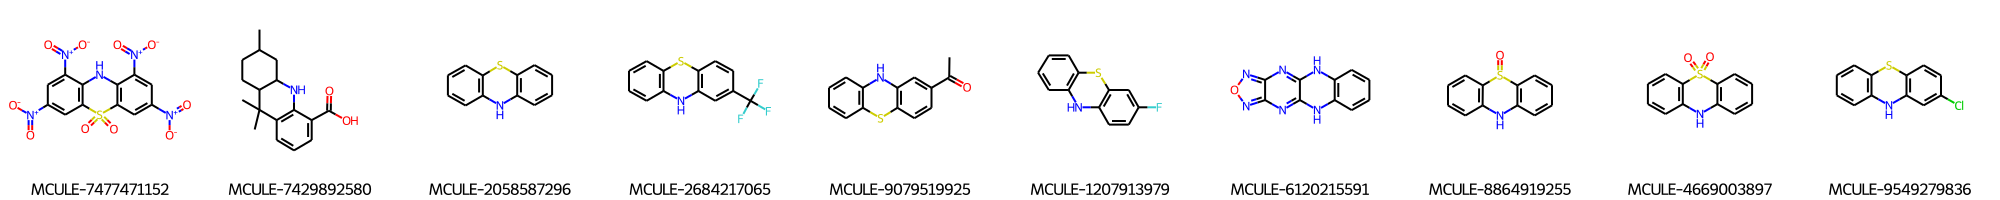

In [15]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

# 이미지 출력
IPythonConsole.ipython_useSVG=True
img = Draw.MolsToGridImage(matched_mols[:10], molsPerRow=10, subImgSize=(200, 200), legends=matched_names, maxMols=50)
img

In [17]:
from rdkit.Chem import MolToSmiles

# csv 파일 저장
with open('matched_molecules.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['id', 'smiles', 'inchikey'])
    for name, mol, key in zip(matched_names, matched_mols, matched_keys):
        writer.writerow([name, MolToSmiles(mol), key])